<a href="https://colab.research.google.com/github/SEOYUNJE/Endoscope-Object-Detection/blob/main/Calibrated-Confidence-Score/gastroscopy_tf_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/seoyunje/gastroscopy-256x256-resized-png')
od.download('https://www.kaggle.com/datasets/msyu78/gastroscopy-meta')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: seoyunje
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/seoyunje/gastroscopy-256x256-resized-png


100%|██████████| 177M/177M [00:01<00:00, 116MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: seoyunje
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/msyu78/gastroscopy-meta


100%|██████████| 802k/802k [00:00<00:00, 109MB/s]

## 1. Import Library
___

In [3]:
!pip install -q colorama

In [4]:
import os
from tqdm import tqdm

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from colorama import Fore

from glob import glob
import cv2
from PIL import Image

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import *
import tensorflow.keras.backend as K

os.environ["CUDA_IS_VISIBLE"] = '0,1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
   strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
   print(f'Using {len(gpus)} GPUs')
else:
   strategy = tf.distribute.MirroredStrategy()
   print(f'Using {len(gpus)} GPUs')

Using 1 GPUs


#### Configuration

In [5]:
class CFG:
    output_dir = 'runs/classify'
    seed = 2025
    img_size = [256,256]

    fold = 0
    num_epochs = 10

    batch_size = 16
    drop_last = False

    label_smoothing = 0.05
    base_lr = 1e-3
    min_lr = 1e-9
    weight_decay = 1e-5

    amp = True
    ema = False

os.makedirs(CFG.output_dir, exist_ok=True)

#### Reproducibility

In [6]:
def seed_everything(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything(CFG.seed)

#### AMP: Auto Mixed Precision

In [7]:
if CFG.amp:
   tf.config.optimizer.set_experimental_options({'auto_mixed_precision': True})
   print('Mixed Precision Enabled')
else:
   print('Using full precision')

Mixed Precision Enabled


## 2. Road and Read Data
___

In [8]:
df = pd.read_csv('/content/gastroscopy-meta/gastroscopy_data2.csv')

train_meta = pd.read_csv('/content/gastroscopy-256x256-resized-png/train_meta.csv')
train_id = train_meta['image_id'].unique()

train_df = df[df['image_id'].isin(train_id)]

test_meta = pd.read_csv('/content/gastroscopy-256x256-resized-png/test_meta.csv')
test_id = test_meta['image_id'].unique()

test_df = df[df['image_id'].isin(test_id)]

In [9]:
## label 0: ulcer
## label 1: polyp
## label 2: cancer

train_df = train_df.groupby(['image_id']).agg('first').reset_index()
train_df = train_df[['image_id','height','width','organ','lesion_label','lesion']]

test_df = test_df.groupby(['image_id']).agg('first').reset_index()
test_df = test_df[['image_id','height','width','organ','lesion_label','lesion']]

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (_, val_idx) in enumerate(skf.split(train_df, train_df['lesion'])):
    train_df.loc[val_idx, 'fold'] = i

**Image File Path**

In [11]:
train_df['width'] = CFG.img_size[0]
train_df['height'] = CFG.img_size[1]

mapping_path = {os.path.basename(x): x for x in glob('/content/gastroscopy-256x256-resized-png/train/*')}
train_df['path'] = train_df['image_id'].map(mapping_path)

test_df['width'] = CFG.img_size[0]
test_df['height'] = CFG.img_size[1]

mapping_path = {os.path.basename(x): x for x in glob('/content/gastroscopy-256x256-resized-png/test/*')}
test_df['path'] = test_df['image_id'].map(mapping_path)

**One Hot Encoding**

In [26]:
for col in train_df['lesion'].unique():
    train_df[col] = np.where(train_df['lesion'].str.contains(col), 1.0, 0.0).astype('float32')
    test_df[col] = np.where(test_df['lesion'].str.contains(col), 1.0, 0.0).astype('float32')


TARGET = train_df['lesion'].unique()
print(TARGET)

['ulcer' 'polyp' 'cancer']


## 3. Build DataGenerator
___

In [13]:
!pip install -q -U git+https://github.com/qubvel/efficientnet

import efficientnet.tfkeras as efn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.2 MB/s eta 0:00:00


In [14]:
import albumentations as A
print(A.__version__)

2.0.4


In [15]:
def get_train_transform():
    return A.Compose(
        [
         A.HorizontalFlip(p=0.5),
         A.Resize(*CFG.img_size, p=1.0)
        ]
    )

def get_valid_transform():
    return A.Compose(
        [
            A.Resize(*CFG.img_size, p=1.0)
        ]
    )

In [16]:
class GastroGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=8, shuffle=False, transforms=None):
        super(GastroGenerator, self).__init__()
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.transforms = transforms
        self.on_epoch_end()

    def __len__(self):
        if not CFG.drop_last:
            ct = int(np.ceil(len(self.data)/self.batch_size))
        else:
            ct = int(np.floor(len(self.data)/self.batch_size))

        return ct

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)

        return X,y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        X = np.zeros((len(indexes), CFG.img_size[0], CFG.img_size[1],3), dtype='float32')
        y = np.zeros((len(indexes), len(TARGET)), dtype='float32')

        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['path']
            img = Image.open(path)
            img = np.array(img)

            m = np.nanmean(img)
            img = np.nan_to_num(img, nan=m)

            if self.transforms:
                sample = self.transforms(image=img)
                img = sample['image']

            X[j,] = efn.preprocess_input(img)
            y[j,] = row[TARGET]

        return X, y

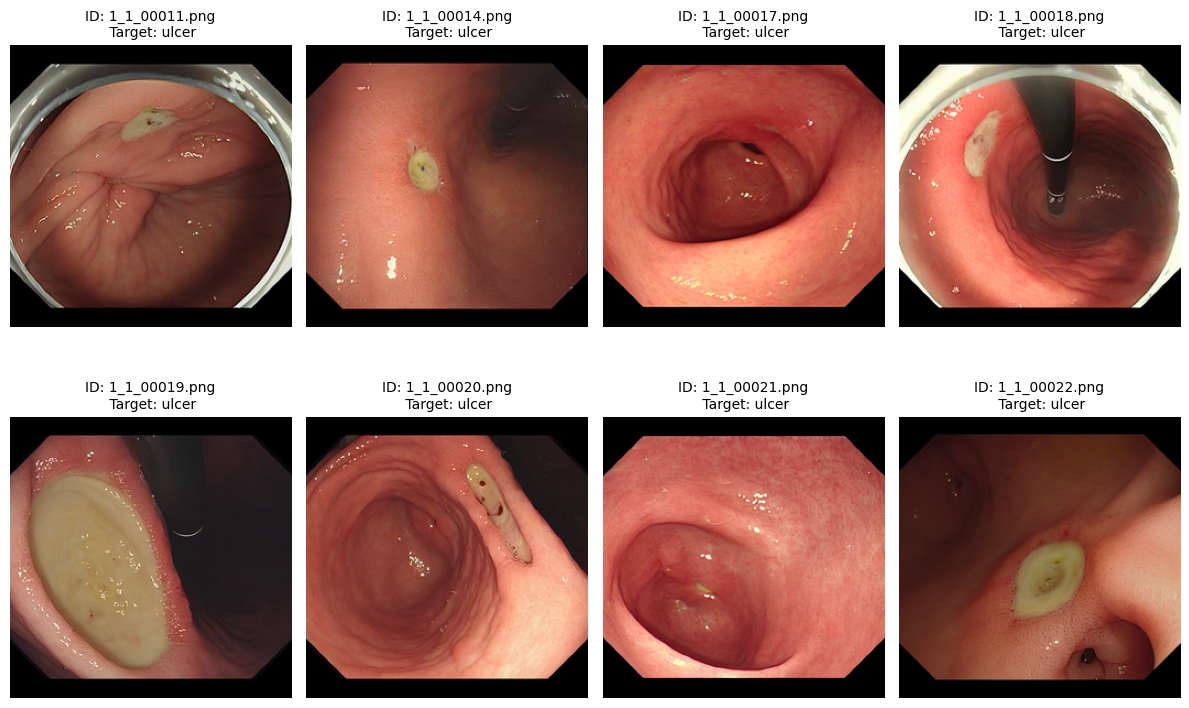

In [38]:
ROWS = 2; COLS = 4; BATCHES = 1

gen = GastroGenerator(train_df, transforms=get_train_transform())

plt.figure(figsize=(12,8))

for i, (x,y) in enumerate(gen):
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS+k+1)
            image_id = train_df.iloc[i*CFG.batch_size+j*COLS+k]['image_id']
            target = train_df.iloc[i*CFG.batch_size+j*COLS+k]['lesion']
            plt.title(f'ID: {image_id}\n Target: {target}', size=10)
            img = x[j*COLS+k,]
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = img * std + mean

            plt.imshow(img)
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    if i == BATCHES - 1: break


## 4. Build EfficientNet Model
___

In [18]:
def build_model():
    feature_only = efn.EfficientNetB0(include_top=False, weights='imagenet', input_shape=None)

    inp = layers.Input(shape=(CFG.img_size[0], CFG.img_size[1],3))
    x = feature_only(inp)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(len(TARGET), activation='sigmoid', dtype='float32')(x)

    model = Model(inputs=inp, outputs=x, name='efficientnet')
    loss = losses.BinaryCrossentropy(label_smoothing=CFG.label_smoothing)
    opt = optimizers.AdamW(learning_rate=CFG.base_lr, weight_decay=CFG.weight_decay,
                           use_ema=CFG.ema, name='adamw')

    model.compile(loss=loss, optimizer=opt)

    return model

**Model Architecture**

In [19]:
K.clear_session()
model = build_model()
model.summary()

16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnet-b0 (Functional)         │ (None, 8, 8, 1280)          │       4,049,564 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,053,407 (15.46 MB)

 Trainable params: 4,011,391 (15.30 MB)

 Non-trainable params: 42,016 (164.12 KB)

**CallBack**

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', patience=2)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_delta=0.01,
                       min_lr=CFG.min_lr, mode='min', verbose=0)

## 5. Train EfficientNet Model
___

In [21]:
all_history = defaultdict(list)

train_gen = GastroGenerator(train_df[train_df['fold'] != CFG.fold], batch_size=CFG.batch_size, shuffle=True, transforms=get_train_transform())
valid_gen = GastroGenerator(train_df[train_df['fold'] == CFG.fold], batch_size=CFG.batch_size*2, shuffle=False, transforms=get_valid_transform())

K.clear_session()
with strategy.scope():
    model = build_model()
    history = model.fit(train_gen, verbose=1, validation_data=valid_gen,
                            epochs=CFG.num_epochs, callbacks=[lr, es])
    model.save_weights(f'{CFG.output_dir}/best_effnet.weights.h5')
    all_history['lr'].extend(history.history['learning_rate'])
    all_history['train_loss'].extend(history.history['loss'])
    all_history['valid_loss'].extend(history.history['val_loss'])

pred = model.predict(valid_gen, verbose=1)
true = train_df[train_df['fold'] == CFG.fold][TARGET].values

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 59s 290ms/step - loss: 0.4004 - val_loss: 0.3437 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 27s 340ms/step - loss: 0.1994 - val_loss: 0.2219 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 281ms/step - loss: 0.1802 - val_loss: 0.1987 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 261ms/step - loss: 0.1571 - val_loss: 0.2245 - learning_rate: 0.0010
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 27s 329ms/step - loss: 0.1431 - val_loss: 0.1624 - learning_rate: 1.0000e-04
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 27s 336ms/step - loss: 0.1354 - val_loss: 0.1593 - learning_rate: 1.0000e-04
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 34s 248ms/step - loss: 0.1302 - val_loss: 0.1593 - learning_rate: 1.0000e-05
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - loss: 0.1301 - val_loss: 0.1600 - learning_rate: 1.0000e-06
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step


**Train Loss, Valid Loss**

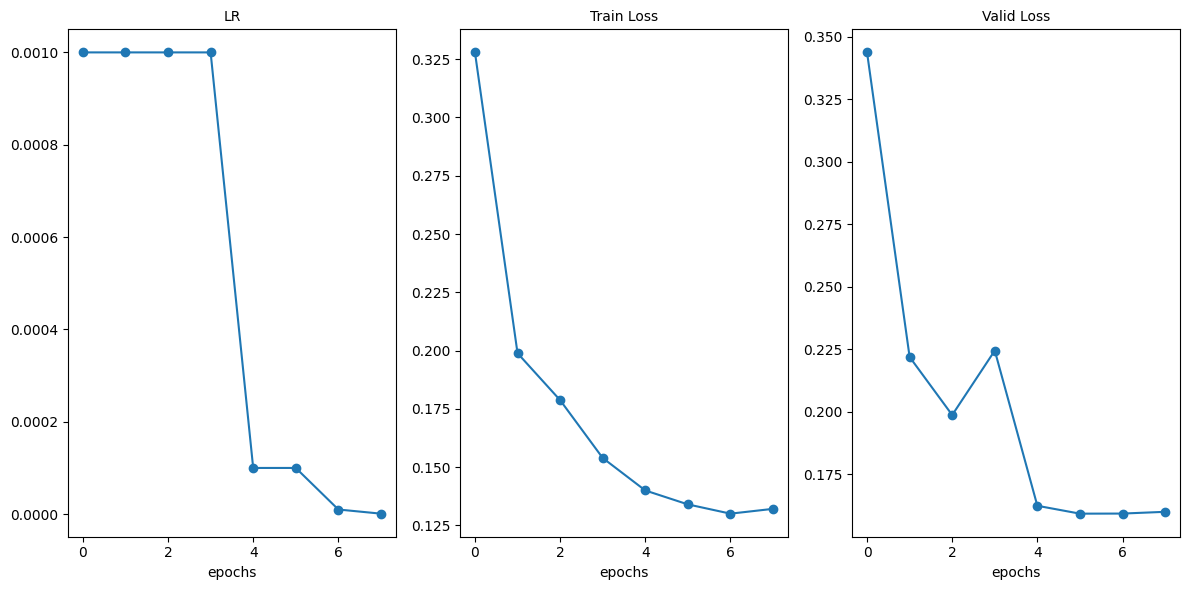

In [22]:
plt.figure(figsize=(12,6))

plt.subplot(1,3,1)
plt.title('LR', size=10)
plt.plot(all_history['lr'], marker='o')
plt.xlabel('epochs')

plt.subplot(1,3,2)
plt.title('Train Loss', size=10)
plt.plot(all_history['train_loss'], marker='o')
plt.xlabel('epochs')


plt.subplot(1,3,3)
plt.title('Valid Loss', size=10)
plt.plot(all_history['valid_loss'], marker='o')
plt.xlabel('epochs')

plt.tight_layout()
plt.show()

**Metric**

In [23]:
threshold = 0.5
pred_thr = (pred >= threshold).astype(int)

for i in range(len(TARGET)):
    precision = precision_score(true[:,i], pred_thr[:,i], average='binary')
    recall = recall_score(true[:,i], pred_thr[:,i], average='binary')
    accuracy = accuracy_score(true[:,i], pred_thr[:,i])

    print(f'{Fore.BLUE}#'*25)
    print(f'Class: {TARGET[i]}')
    print(f'#'*25)
    print(f'{Fore.BLACK}Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Accuracy: {accuracy}')
    print('\n')

#########################
Class: ulcer
#########################
Precision: 0.9629629629629629
Recall: 0.975
Accuracy: 0.984375


#########################
Class: polyp
#########################
Precision: 0.961038961038961
Recall: 0.925
Accuracy: 0.971875


#########################
Class: cancer
#########################
Precision: 0.9936305732484076
Recall: 0.975
Accuracy: 0.984375




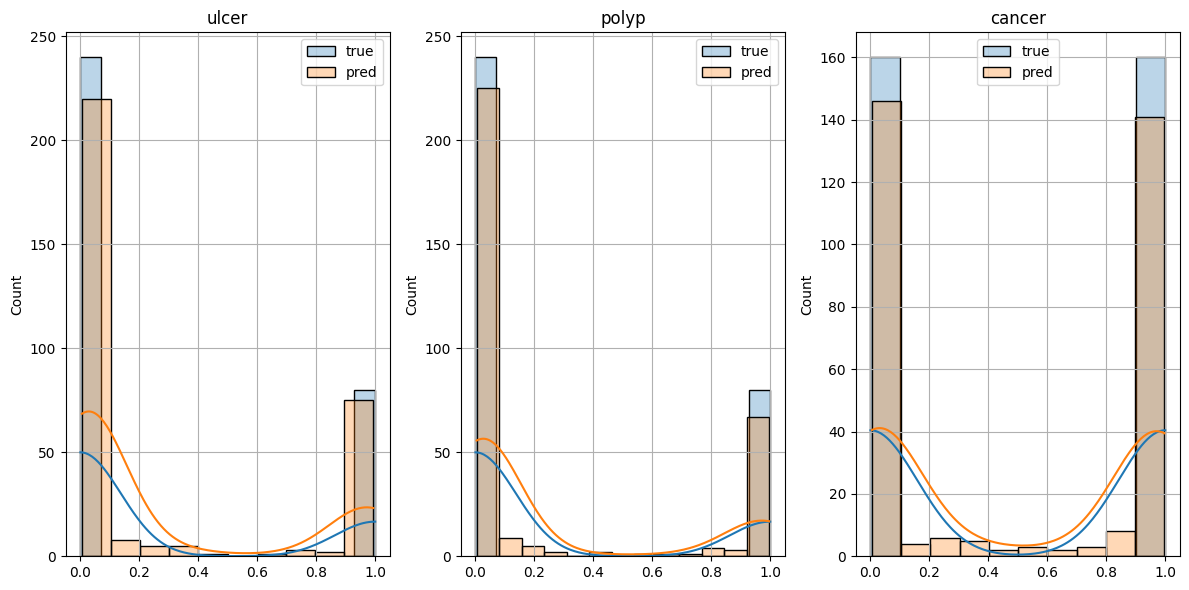

In [24]:
plt.figure(figsize=(12,6))

for i in range(len(TARGET)):
    plt.subplot(1,3,i+1)
    plt.title(TARGET[i])
    sns.histplot(true[:,i], alpha=0.3, kde=True, label='true')
    sns.histplot(pred[:,i], alpha=0.3, kde=True, label='pred')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## 6. Inference
___

In [28]:
test_gen = GastroGenerator(test_df, batch_size=CFG.batch_size*2, shuffle=False, transforms=get_valid_transform())

K.clear_session()
with strategy.scope(): model = build_model()

model.load_weights(f'{CFG.output_dir}/best_effnet.weights.h5')

test_pred = model.predict(test_gen, verbose=1)
test_true = test_df[TARGET].values

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step


In [29]:
threshold = 0.5
test_pred_thr = (test_pred >= threshold).astype(int)

for i in range(len(TARGET)):
    precision = precision_score(test_true[:,i], test_pred_thr[:,i], average='binary')
    recall = recall_score(test_true[:,i], test_pred_thr[:,i], average='binary')
    accuracy = accuracy_score(test_true[:,i], test_pred_thr[:,i])

    print(f'{Fore.BLUE}#'*25)
    print(f'Class: {TARGET[i]}')
    print(f'#'*25)
    print(f'{Fore.BLACK}Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Accuracy: {accuracy}')
    print('\n')

#########################
Class: ulcer
#########################
Precision: 0.98
Recall: 0.98
Accuracy: 0.99


#########################
Class: polyp
#########################
Precision: 0.9795918367346939
Recall: 0.96
Accuracy: 0.985


#########################
Class: cancer
#########################
Precision: 0.9752475247524752
Recall: 0.985
Accuracy: 0.98




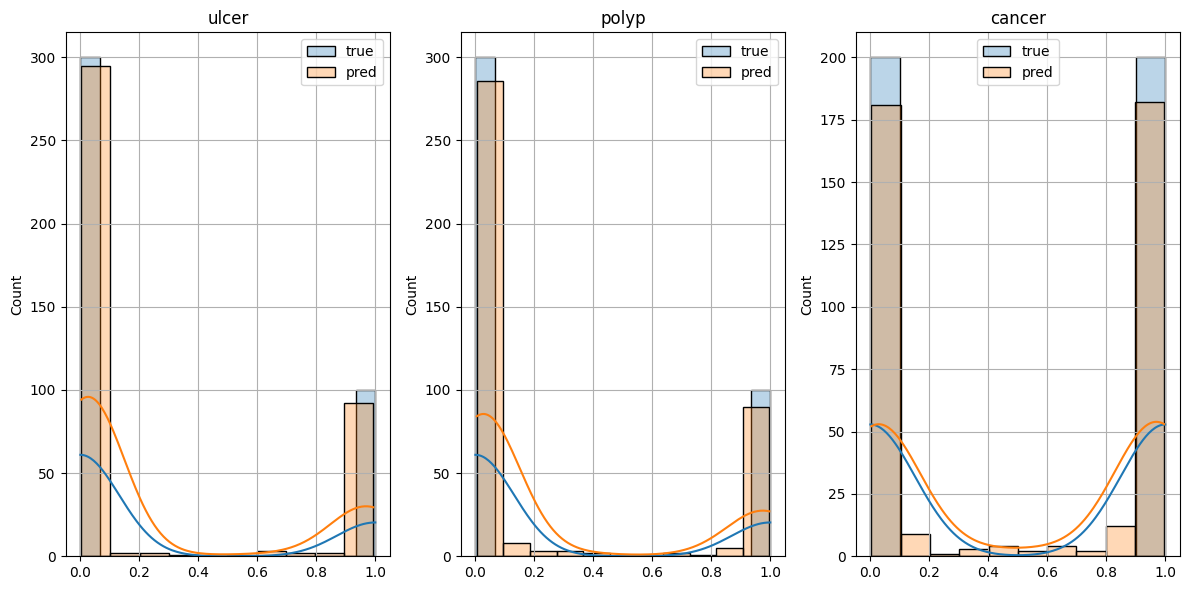

In [30]:
plt.figure(figsize=(12,6))

for i in range(len(TARGET)):
    plt.subplot(1,3,i+1)
    plt.title(TARGET[i])
    sns.histplot(test_true[:,i], alpha=0.3, kde=True, label='true')
    sns.histplot(test_pred[:,i], alpha=0.3, kde=True, label='pred')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [35]:
pred_df = pd.DataFrame(test_pred)
pred_df.rename(columns={0: 'ulcer', 1: 'polyp', 2: 'cancer'})

,ulcer,polpy,cancer
0,0.985473,0.021284,0.017999
1,0.048331,0.977237,0.012016
2,0.513462,0.046980,0.425546
3,0.984551,0.020564,0.016227
4,0.971248,0.030325,0.017930
...,...,...,...
395,0.018200,0.019754,0.984646
396,0.011669,0.030846,0.980257
397,0.017415,0.021530,0.979329
398,0.024478,0.019158,0.988764


In [36]:
pred_df.to_csv('submission.csv', index=False)